In [46]:
import sqlite3
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools as it
import argparse
import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
from matchms.Spectrum import Spectrum
from sklearn.model_selection import GroupShuffleSplit

from ssvm.data_structures import RandomSubsetCandidateSQLiteDB, CandidateSQLiteDB, SequenceSample
from ssvm.ssvm import StructuredSVMSequencesFixedMS2

In [2]:
DB_FN = "/home/bach/Documents/doctoral/projects/local_casmi_db/db/use_inchis/DB_LATEST.db"

In [6]:
# ===================
# Get list of Spectra
# ===================
db = sqlite3.connect_to_db("file:" + DB_FN + "?mode=ro", uri=True)

# Read in spectra and labels
res = pd.read_sql_query("SELECT spectrum, inchikey1 as molecule, rt, challenge FROM challenges_spectra "
                        "   INNER JOIN spectra s ON s.name = challenges_spectra.spectrum"
                        "   INNER JOIN molecules m on m.inchi = s.molecule", con=db)
spectra = [Spectrum(np.array([]), np.array([]),
                    {"spectrum_id": spec_id, "retention_time": rt, "dataset": chlg, "molecule_id": mol})
           for (spec_id, rt, chlg, mol) in zip(res["spectrum"], res["rt"], res["challenge"], res["molecule"])]
labels = res["molecule"].to_list()
datasets = res["challenge"].to_list()

db.close()

In [10]:
# ======================
# Get training sequences
# ======================
test = [idx for idx in range(len(spectra)) if datasets[idx] == "negative"]  # take negative CASMI challenge data
labels_test = [labels[idx] for idx in test]
train = [idx for idx in range(len(spectra)) if (idx not in test) and (labels[idx] not in labels_test)]

assert not len(set(test) & set(train))

training_sequences = SequenceSample(
    [spectra[idx] for idx in train], [labels[idx] for idx in train],
    RandomSubsetCandidateSQLiteDB(db_fn=DB_FN, molecule_identifier="inchikey1", random_state=2, number_of_candidates=100, include_correct_candidate=True),
    N=250,
    L_min=5,
    L_max=20,
    random_state=19,
    ms2scorer="MetFrag_2.4.5__8afe4a14")

In [14]:
ssvm = StructuredSVMSequencesFixedMS2(
        mol_feat_label_loss="iokr_fps__positive", mol_feat_retention_order="substructure_count",
        mol_kernel="minmax_numba", C=1, step_size="linesearch", batch_size=8,
        n_epochs=5, label_loss="tanimoto_loss", random_state=1993,
        retention_order_weight=0.5
    ).fit(training_sequences, n_init_per_example=6)

Epoch: 1/5
	Step: 1/32
	0.0577
	n_active=1500 (before update)
[True, True, True, True, True, True, True, True]
	n_active=1508 (after update)
CacheInfo(hits=7538, misses=560, maxsize=None, currsize=560)

	Step: 2/32
	0.1137
	n_active=1508 (before update)
[True, True, True, True, True, True, True, True]
	n_active=1516 (after update)
CacheInfo(hits=11534, misses=620, maxsize=None, currsize=620)

	Step: 3/32
	0.0325
	n_active=1516 (before update)
[True, True, True, True, True, True, True, True]
	n_active=1524 (after update)
CacheInfo(hits=15526, misses=684, maxsize=None, currsize=684)

	Step: 4/32
	0.1314
	n_active=1524 (before update)
[True, True, True, True, True, True, True, True]
	n_active=1532 (after update)
CacheInfo(hits=19518, misses=748, maxsize=None, currsize=748)

	Step: 5/32
	0.0742
	n_active=1532 (before update)
[True, True, True, True, True, True, True, True]
	n_active=1540 (after update)
CacheInfo(hits=23510, misses=812, maxsize=None, currsize=812)

	Step: 6/32
	0.0477
	n_ac

In [97]:
ssvm_init = StructuredSVMSequencesFixedMS2(
        mol_feat_label_loss="iokr_fps__positive", mol_feat_retention_order="substructure_count",
        mol_kernel="minmax_numba", C=1, step_size="linesearch", batch_size=8,
        n_epochs=0, label_loss="tanimoto_loss", random_state=1993,
        retention_order_weight=0.5
    ).fit(training_sequences, n_init_per_example=6)

In [105]:
def load_fps(df):
    db = sqlite3.connect_to_db("file:" + DB_FN + "?mode=ro", uri=True)

    res_fps = pd.read_sql_query("SELECT s.name AS spectrum, substructure_count FROM fingerprints_data "
                                "   INNER JOIN spectra s ON fingerprints_data.molecule = s.molecule "
                                "   WHERE s.name IN %s" % CandidateSQLiteDB._in_sql(df["spectrum"]),
                                con=db, index_col="spectrum")

    Y = np.zeros((len(res_fps), 307))
    fps = res_fps.loc[df["spectrum"]]["substructure_count"]
    for i, fp_str in enumerate(fps): 
        for fp in fp_str.split(","):
            _idx, _cnt = fp.split(":")
            Y[i, int(_idx)] = int(_cnt)

    db.close()
    
    return Y

Y_train = load_fps(res.iloc[train, :])
Y_test = load_fps(res.iloc[test, :])

# RankSVM
db = sqlite3.connect_to_db("file:" + DB_FN + "?mode=ro", uri=True)

res_rsvm = pd.read_sql_query("SELECT s.name AS spectrum, score from preference_scores_data "
                             "   INNER JOIN spectra s ON preference_scores_data.molecule = s.molecule "
                             "   WHERE s.name IN %s AND setting IS 'c6d6f521'" 
                                 % CandidateSQLiteDB._in_sql(res.iloc[test, :]["spectrum"]),
                             con=db, index_col="spectrum")

rsvm_pref = res_rsvm.loc[res.iloc[test, :]["spectrum"]]["score"].values

db.close()

Text(0.5, 0, 'Retention time')

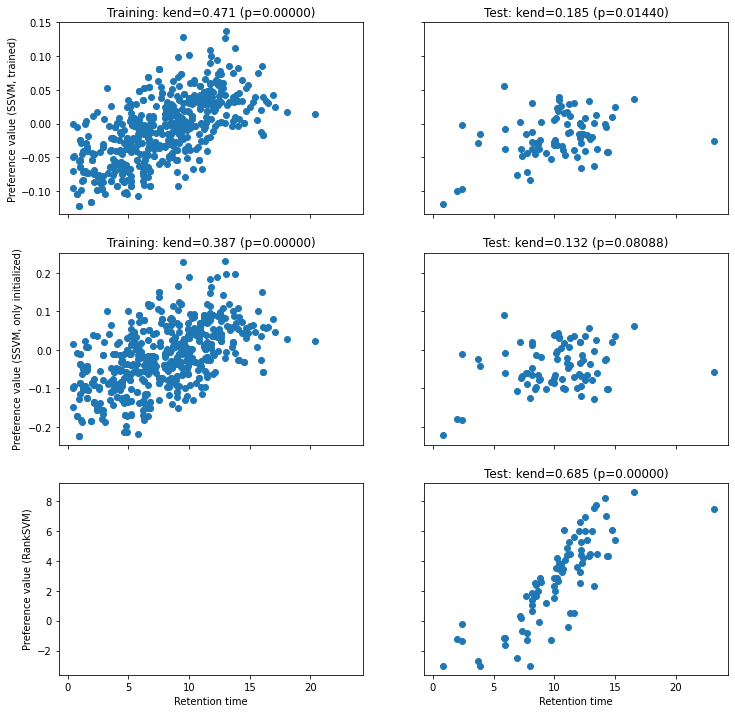

In [106]:
from scipy.stats import kendalltau

fig, axrr = plt.subplots(3, 2, figsize=(12, 12), sharey="row", sharex=True)

p_train = ssvm.predict_molecule_preference_values(Y_train)
p_test = ssvm.predict_molecule_preference_values(Y_test)

p_init_only_train = ssvm_init.predict_molecule_preference_values(Y_train)
p_init_only_test = ssvm_init.predict_molecule_preference_values(Y_test)

p_rsvm_test = rsvm_pref

axrr[0, 0].scatter(res.iloc[train, :]["rt"], p_train)
axrr[0, 1].scatter(res.iloc[test, :]["rt"], p_test)
axrr[1, 0].scatter(res.iloc[train, :]["rt"], p_init_only_train)
axrr[1, 1].scatter(res.iloc[test, :]["rt"], p_init_only_test)
axrr[2, 1].scatter(res.iloc[test, :]["rt"], p_rsvm_test)

axrr[0, 0].set_title("Training: kend=%.3f (p=%.5f)" % kendalltau(res.iloc[train, :]["rt"], p_train))
axrr[0, 1].set_title("Test: kend=%.3f (p=%.5f)" % kendalltau(res.iloc[test, :]["rt"], p_test))
axrr[1, 0].set_title("Training: kend=%.3f (p=%.5f)" % kendalltau(res.iloc[train, :]["rt"], p_init_only_train))
axrr[1, 1].set_title("Test: kend=%.3f (p=%.5f)" % kendalltau(res.iloc[test, :]["rt"], p_init_only_test))
axrr[2, 1].set_title("Test: kend=%.3f (p=%.5f)" % kendalltau(res.iloc[test, :]["rt"], p_rsvm_test))

axrr[0, 0].set_ylabel("Preference value (SSVM, trained)")
axrr[1, 0].set_ylabel("Preference value (SSVM, only initialized)")
axrr[2, 0].set_ylabel("Preference value (RankSVM)")
axrr[2, 0].set_xlabel("Retention time")
axrr[2, 1].set_xlabel("Retention time")